# ECEN 5672 – DIGITAL IMAGE PROCESSING - ASSIGNMENT 04 (Module 7 & 8) 

## Problem 1: Structural Similarity Index (SSIM)  

The goal of this problem is to analyze the Structural Similarity (SSIM) Index and study how luminance, contrast, and structure contribute to image-quality perception

A) Read the given image Lion.jpg and convert it to grayscale. Create two modified versions: 

i. 
A blurred version (using a Gaussian filter)( σ = 0.8) 

ii. A contrast-reduced version (by scaling intensities). 
Display the three images (original, blurred, contrast-reduced) and label them clearly.

In [3]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

imageLion = img.imread('Lion.jpg')

if imageLion.max() > 1.0:
    imageLion = imageLion / 255.0
    
# Extract RGB channels
# asked chatgpt how to index into an img array
red = imageLion[:,:,0]
green = imageLion[:,:,1]
blue = imageLion[:,:,2]

gamma = 1.04
r_const = 0.299
g_const = 0.587
b_const = 0.114

grayscaleLion = np.clip((r_const * red   ** gamma +
                         g_const * green ** gamma +
                         b_const * blue  ** gamma), 0.0, 1.0).astype(np.float32)


def gaussian(x, y, sigma):
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))

def gaussian_filter(image, window_size, sigma):

    H,W = image.shape
    pad = window_size // 2

    # create a coordinate gride at 0
    u = np.arange(-pad, pad + 1)
    v = np.arange(-pad, pad + 1)
    U, V = np.meshgrid(u, v)

    #create a gaussian kernel
    kernel = gaussian(U, V, sigma)
    kernel = kernel / np.sum(kernel)
    
    paddedImg = np.pad(image, pad, mode='reflect')
    filteredImg = np.zeros((H,W))

    for i in range(H):
        for j in range(W):
            win = paddedImg[i:i+window_size, j:j+window_size]
            filteredImg[i, j] = np.sum(win * kernel)

    return np.clip(filteredImg, 0.0, 1.0)

gaussianLion = gaussian_filter(grayscaleLion, 15, 80)


contrast_scale = 0.5
contrastLion = (grayscaleLion - 0.5) * contrast_scale + 0.5
contrastLion = np.clip(contrastLion, 0.0, 1.0)


# 2 row, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Original image
axes[0][0].imshow(imageLion)
axes[0][0].axis('off')
axes[0][0].set_title("Original Image")

# Grayscale image
axes[0][1].imshow(grayscaleLion, cmap='gray', vmin=0.0, vmax=1.0)
axes[0][1].axis('off')
axes[0][1].set_title("Grayscale")

axes[1][0].imshow(gaussianLion, cmap='gray', vmin=0.0, vmax=1.0)
axes[1][0].axis('off')
axes[1][0].set_title("Gassian Filter")

# Grayscale image
axes[1][1].imshow(contrastLion, cmap='gray', vmin=0.0, vmax=1.0)
axes[1][1].axis('off')
axes[1][1].set_title("Contrast Reduced")

plt.tight_layout()
plt.show()


B)  Compute the local mean and standard deviation within 11×11 neighbourhoods for all three images. Display the resulting local-mean and standard-deviation maps. Comment briefly on how blur and contrast reduction alter these statistics.

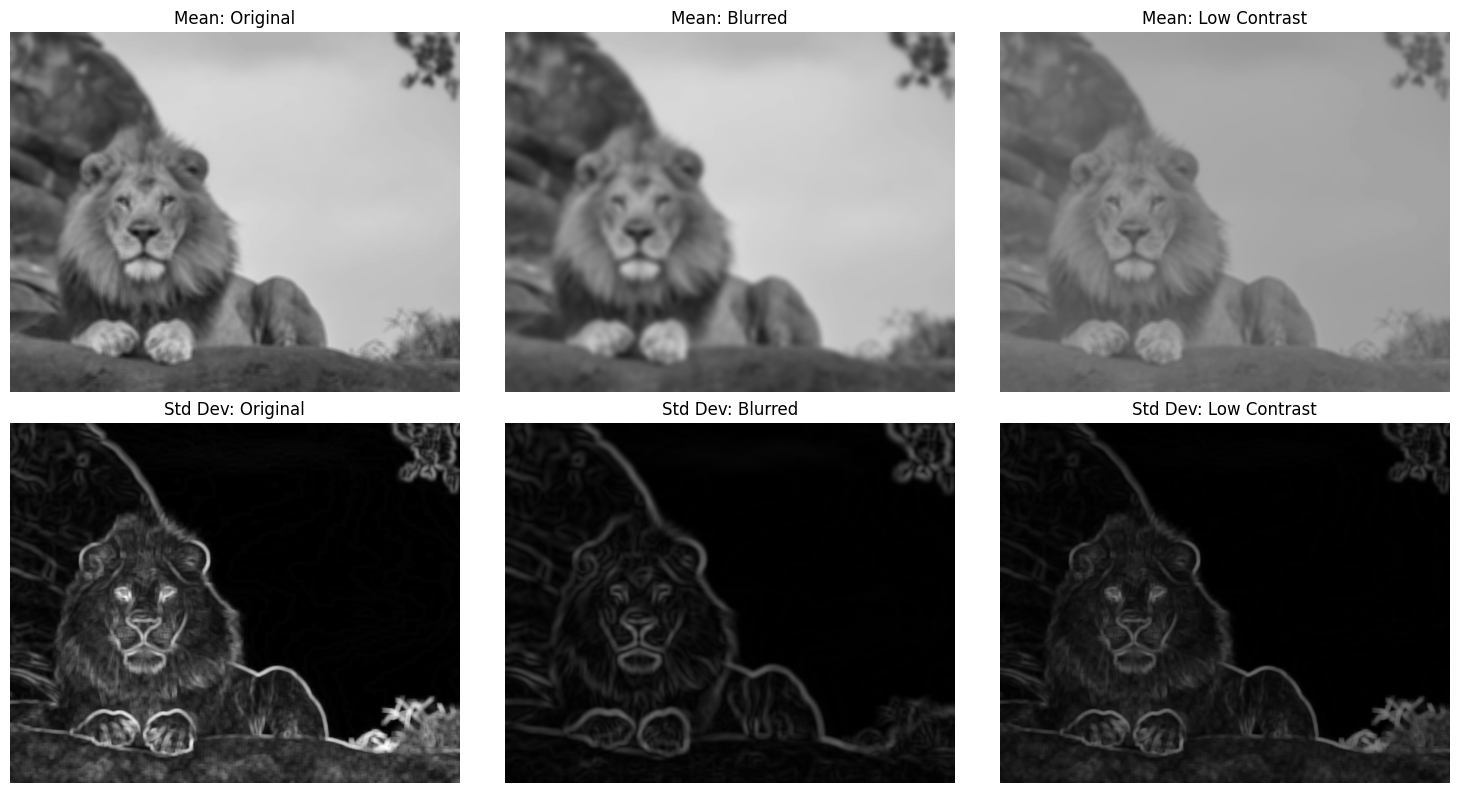

In [4]:

def getPixelNeighborhood(center_row, center_col, image, window_size):
    height, width = image.shape
    half_win = window_size // 2
    pixels = []

    for dr in range(-half_win, half_win + 1):
        for dc in range(-half_win, half_win + 1):
            r = int(center_row + dr)
            c = int(center_col + dc)

            if r < 0 or  r >= height or c < 0 or c >= width:
                r_clipped = np.clip(r, 0, (height - 1))
                c_clipped = np.clip(c, 0, (width - 1))
                pixels.append(image[r_clipped, c_clipped])
            else:
                pixels.append(image[r][c])
                
    return np.array(pixels)


def get_images(image, window_size):
    H,W = image.shape
    filteredMeanImg = np.zeros((H,W))
    filteredSTDImg = np.zeros((H,W))

    for i in range(H):
        for j in range(W):    
            neighborhood = getPixelNeighborhood(i, j, image, window_size)
            filteredMeanImg[i,j] = np.mean(neighborhood)
            filteredSTDImg[i,j] = np.std(neighborhood)

    return filteredMeanImg, filteredSTDImg


block_size = 11

imgGrayscaleMean, imgGrayscaleSTDs = get_images(grayscaleLion, block_size)
imgGuassianMean, imgGuassianSTDs = get_images(gaussianLion, block_size)
imgContrastMean, imgContrastSTDs = get_images(contrastLion, block_size)


# --- DISPLAY RESULTS ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Local Means
axes[0, 0].imshow(imgGrayscaleMean, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title("Mean: Original")
axes[0, 0].axis('off')

axes[0, 1].imshow(imgGuassianMean, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title("Mean: Blurred")
axes[0, 1].axis('off')

axes[0, 2].imshow(imgContrastMean, cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title("Mean: Low Contrast")
axes[0, 2].axis('off')

# Row 2: Standard Deviations
axes[1, 0].imshow(imgGrayscaleSTDs, cmap='gray', vmin=0, vmax=0.3)
axes[1, 0].set_title("Std Dev: Original")
axes[1, 0].axis('off')

axes[1, 1].imshow(imgGuassianSTDs, cmap='gray', vmin=0, vmax=0.3)
axes[1, 1].set_title("Std Dev: Blurred")
axes[1, 1].axis('off')

axes[1, 2].imshow(imgContrastSTDs, cmap='gray', vmin=0, vmax=0.3)
axes[1, 2].set_title("Std Dev: Low Contrast")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

Compute the luminance similarity (L), contrast similarity (C), and structure similarity (S) maps between the reference and each modified image using the constants: $C_1 = (0.01 * L_{max})^2, C_2 = (0.03 * L_{max})^2, C_3 = C_2/2$

Combine the three components to form the SSIM map and compute the mean SSIM 
index. Show all four maps (L, C, S, and SSIM) in a 2×2 grid. 
Briefly describe which component contributes most to the visual difference between 
the original and each distorted image.

In [5]:
def compute_luminance(mu_x, mu_y, C1):
    num_L = 2 * mu_x * mu_y + C1
    den_L = mu_x**2 + mu_y**2 + C1
    return num_L / den_L

def compute_contrast(sigma_x, sigma_y, C2):
    num_C = 2 * sigma_x * sigma_y + C2
    den_C = sigma_x**2 + sigma_y**2 + C2
    return num_C / den_C

def compute_structure(sigma_xy, sigma_x, sigma_y, C3):
    num_S = sigma_xy + C3
    den_S = sigma_x * sigma_y + C3
    return num_S / den_S
    
def compute_ssim_maps(img_ref, img_dist, window_size=11, L_max=255.0):
    H, W = img_ref.shape
    
    scaled_ref = img_ref * 255.0
    scaled_dist = img_dist * 255.0

    C1 = (0.01 * L_max) ** 2
    C2 = (0.03 * L_max) ** 2
    C3 = C2 / 2
    
    map_L = np.zeros((H, W))
    map_C = np.zeros((H, W))
    map_S = np.zeros((H, W))
    map_SSIM = np.zeros((H, W))
    
    for i in range(H):
        for j in range(W):
            win_ref = getPixelNeighborhood(i, j, scaled_ref, window_size)
            win_dist = getPixelNeighborhood(i, j, scaled_dist, window_size)
            
            mu_x = np.mean(win_ref)
            mu_y = np.mean(win_dist)
            
            sigma_x = np.std(win_ref)
            sigma_y = np.std(win_dist)
            
            sigma_xy = np.mean(win_ref * win_dist) - (mu_x * mu_y)
            
            L = compute_luminance(mu_x, mu_y, C1)
            C = compute_contrast(sigma_x, sigma_y, C2)
            S = compute_structure(sigma_xy, sigma_x, sigma_y, C3)
            
            map_L[i, j] = L
            map_C[i, j] = C
            map_S[i, j] = S
            map_SSIM[i, j] = L * C * S

    return map_L, map_C, map_S, map_SSIM

Mean SSIM (Gauss): 0.7250


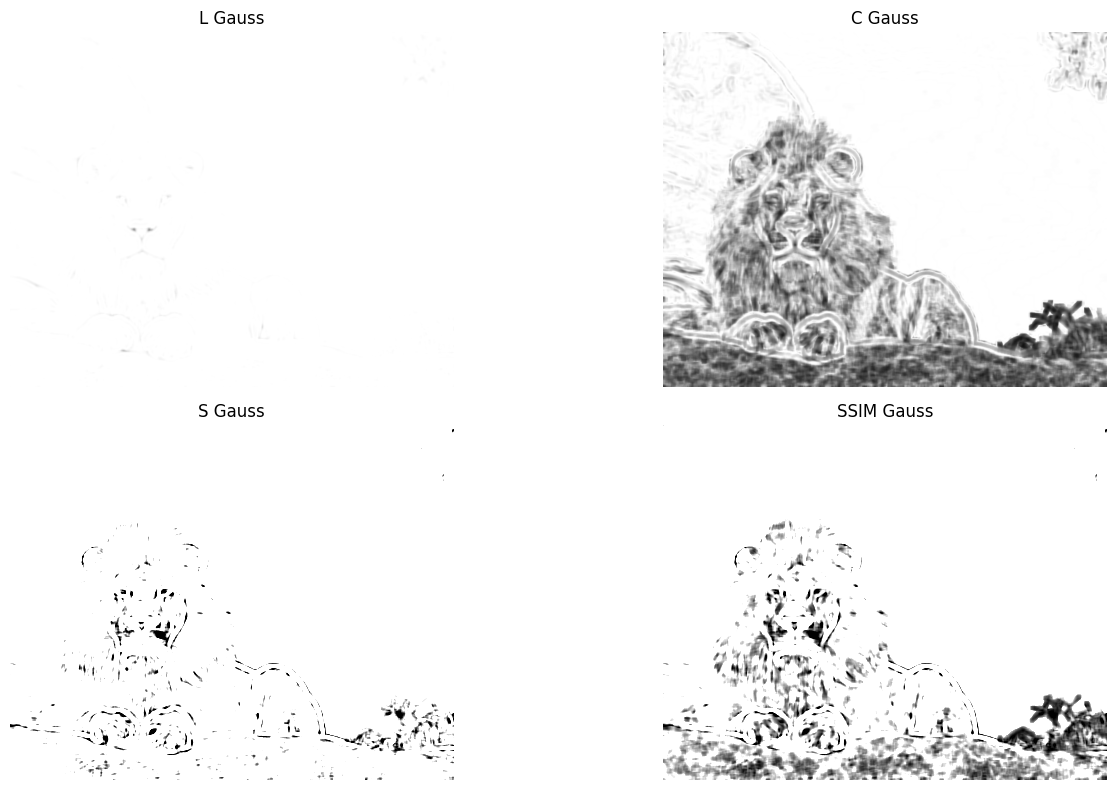

Mean SSIM (Contrast): 0.8900


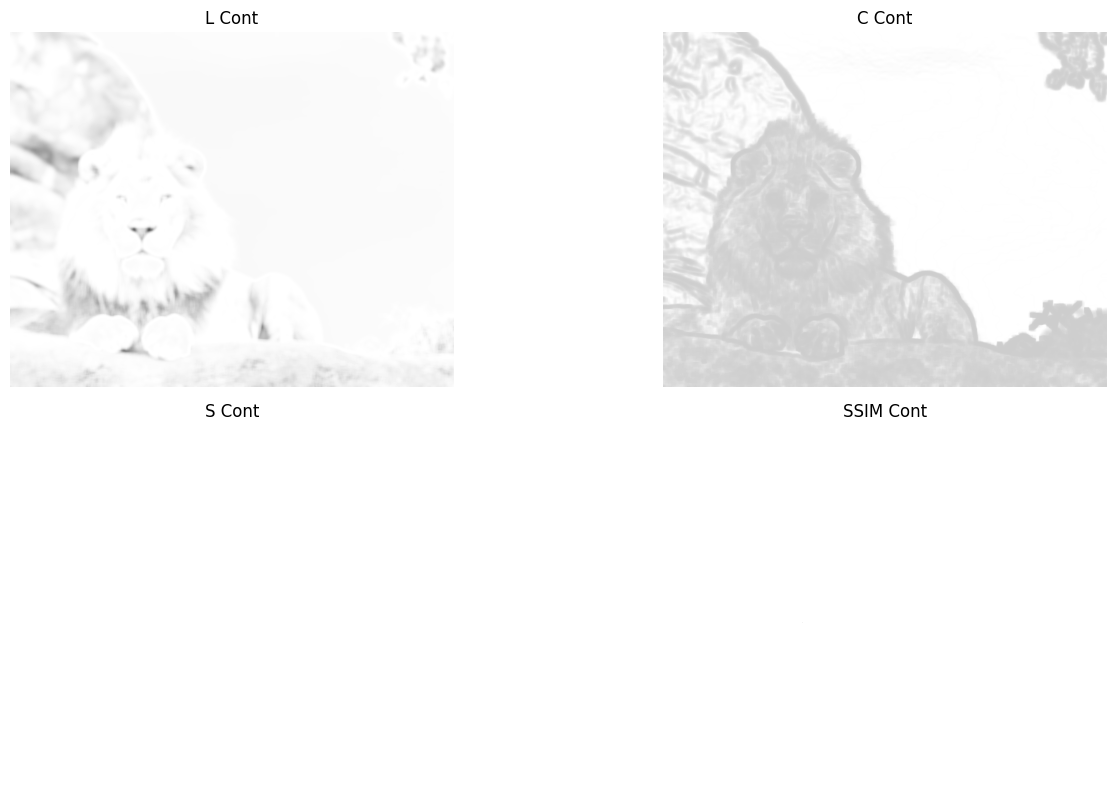

In [6]:
L_gauss, C_gauss, S_gauss, SSIM_gauss = compute_ssim_maps(grayscaleLion, gaussianLion)
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Row 1:
axes[0, 0].imshow(L_gauss, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title("L Gauss")
axes[0, 0].axis('off')

axes[0, 1].imshow(C_gauss, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title("C Gauss")
axes[0, 1].axis('off')

# Row 2:
axes[1, 0].imshow(S_gauss, cmap='gray', vmin=0, vmax=0.3)
axes[1, 0].set_title("S Gauss")
axes[1, 0].axis('off')

axes[1, 1].imshow(SSIM_gauss, cmap='gray', vmin=0, vmax=0.3)
axes[1, 1].set_title("SSIM Gauss")
axes[1, 1].axis('off')

print(f"Mean SSIM (Gauss): {np.mean(SSIM_gauss):.4f}")

plt.tight_layout()
plt.show()


L_cont, C_cont, S_cont, SSIM_cont = compute_ssim_maps(grayscaleLion, contrastLion)
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Row 1:
axes[0, 0].imshow(L_cont, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title("L Cont")
axes[0, 0].axis('off')

axes[0, 1].imshow(C_cont, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title("C Cont")
axes[0, 1].axis('off')

# Row 2:
axes[1, 0].imshow(S_cont, cmap='gray', vmin=0, vmax=0.3)
axes[1, 0].set_title("S Cont")
axes[1, 0].axis('off')

axes[1, 1].imshow(SSIM_cont, cmap='gray', vmin=0, vmax=0.3)
axes[1, 1].set_title("SSIM Cont")
axes[1, 1].axis('off')

print(f"Mean SSIM (Contrast): {np.mean(SSIM_cont):.4f}")

plt.tight_layout()
plt.show()


gaussian iamage:

Contrast seems to be the most changed component for gaussian. The blur altered all the pixels with the local 11x11 neighbors which varies a lot, espeically over the lion and rocks. The structure, on the other hand has much less spanning changes as contrast. though it does has deeper blacks, which i believe means theres a greater change since the gaussian blur heavily distorts the edges of objects.

Contrast image:

The contrast most affects the image output, which makes sense since the distorition addedd was strictly to the contrast of the image. The images are the same structurally, which is why the image is white. Changing contrast does not affect the structural material of the image. This also explains why the lumanince is also slightly changes as well as we did change the overall brightness of the image when we compressed the contrast range down. 

Introduce two additional modifications:

i. A uniform brightness shift (+30 grey levels) to illustrate luminance masking 
behaviour.

ii. A local contrast boost (to illustrate contrast masking). 
Compute and compare only the L and C maps for these cases, and relate your 
observations to the concept of masking.

Mean SSIM (Gauss): 0.7250


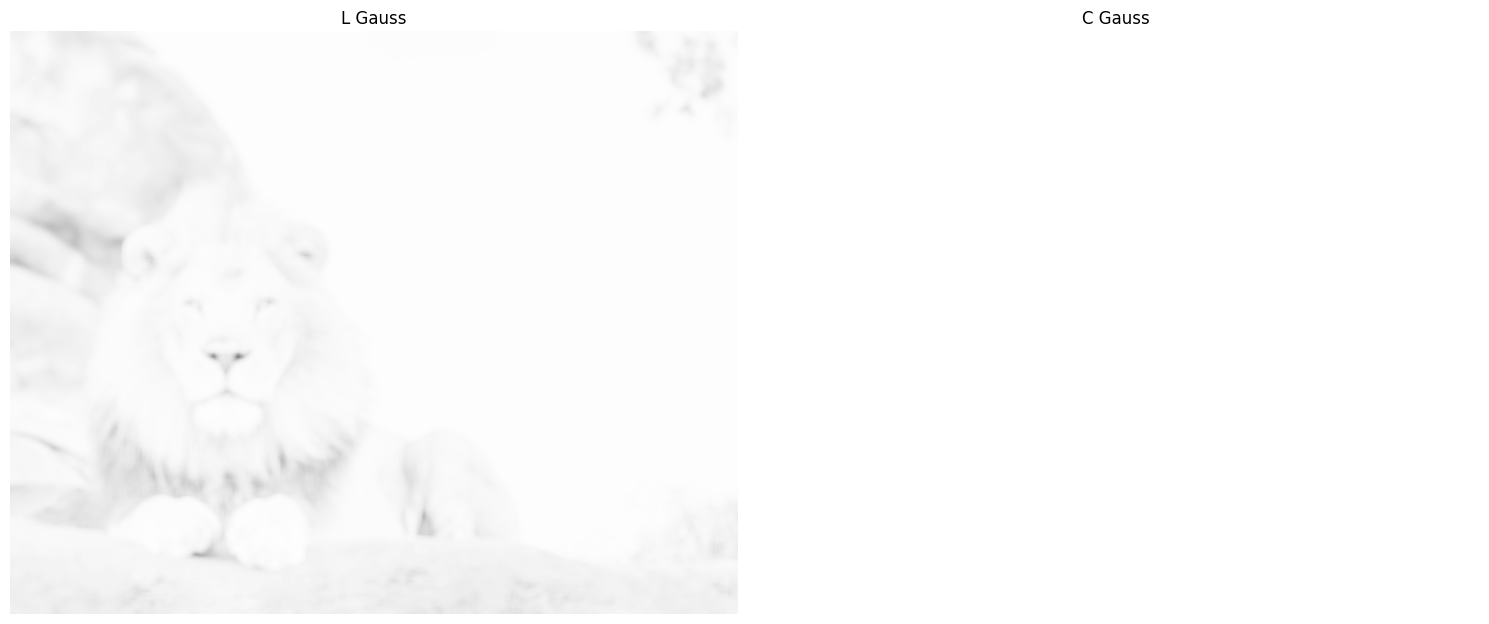

Mean SSIM (Contrast): 0.7250


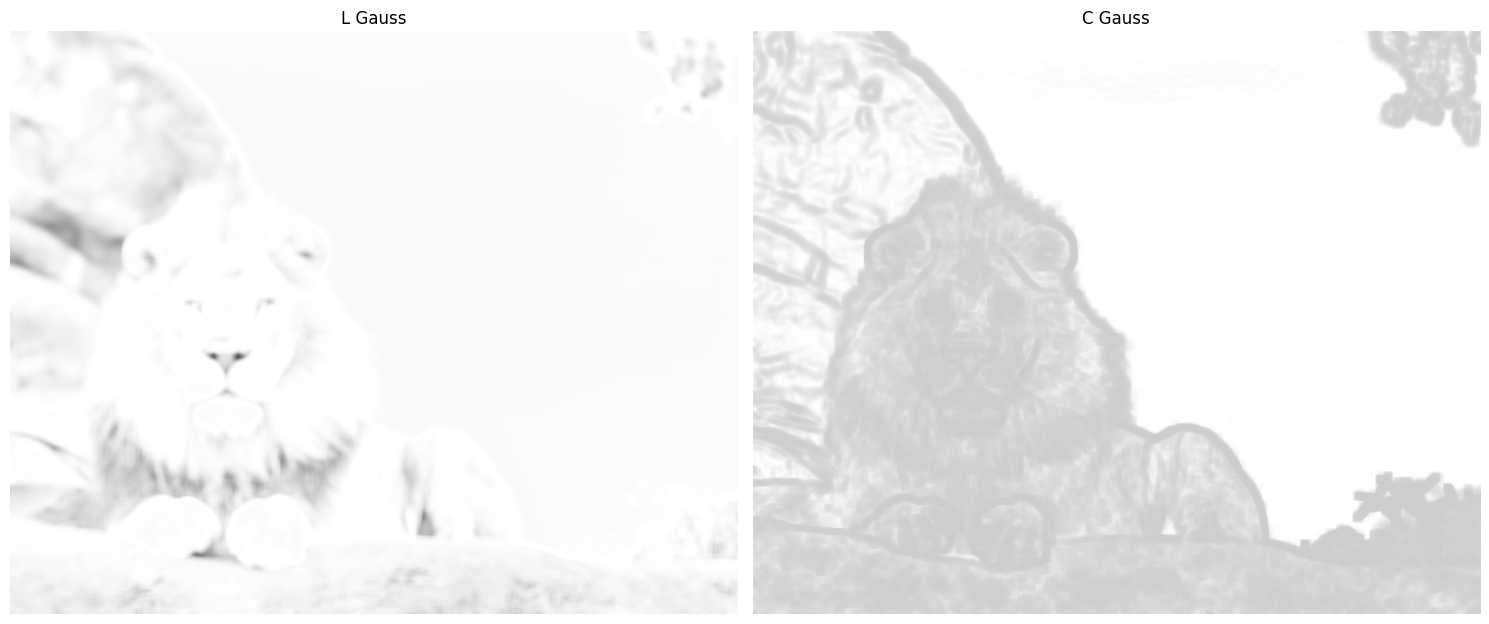

In [7]:
shift_amount = 30.0 / 255.0

brightLion = grayscaleLion + shift_amount

L_bright, C_bright, S_bright, SSIM_bright = compute_ssim_maps(grayscaleLion, brightLion)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Row 1:
axes[0].imshow(L_bright, cmap='gray', vmin=0, vmax=1)
axes[0].set_title("L Gauss")
axes[0].axis('off')

axes[1].imshow(C_bright, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("C Gauss")
axes[1].axis('off')

print(f"Mean SSIM (Gauss): {np.mean(SSIM_gauss):.4f}")

plt.tight_layout()
plt.show()


contrast_scale = 1.5
contrastLion2 = (grayscaleLion - 1.5) * contrast_scale + 1.5
contrastLion2 = np.clip(contrastLion, 0.0, 1.0)

L_contrast , C_contrast , S_contrast , SSIM_contrast  = compute_ssim_maps(grayscaleLion, contrastLion2)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Row 1:
axes[0].imshow(L_contrast, cmap='gray', vmin=0, vmax=1)
axes[0].set_title("L Gauss")
axes[0].axis('off')

axes[1].imshow(C_contrast, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("C Gauss")
axes[1].axis('off')

print(f"Mean SSIM (Contrast): {np.mean(SSIM_gauss):.4f}")

plt.tight_layout()
plt.show()


Generate three further distortions – JPEG compression, motion blur, and salt-and-pepper noise. 
Compute PSNR and mean SSIM for each distorted image and summarize the results in a 
table. 
Discuss in 3–4 sentences why SSIM aligns better with perceived quality than PSNR for 
these distortions.

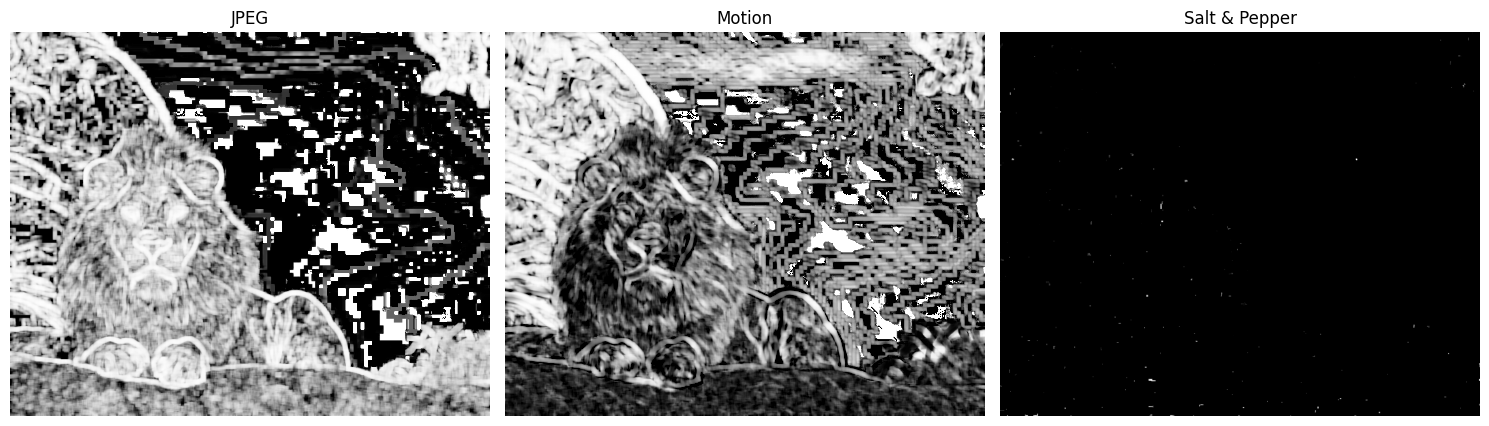

Distortion Type      | PSNR (dB)  | Mean SSIM 
----------------------------------------------
JPEG Compression     | 29.48      | 0.518     
Motion Blur          | 26.02      | 0.513     
Salt & Pepper        | -35.08     | 0.001     


In [12]:
from PIL import Image
import io
import scipy.ndimage as ndimage

# --- 1. JPEG Compression ---
def apply_jpeg(image, quality=10):
    # Convert 0-1 float to 0-255 uint8 for PIL
    img_uint8 = (image * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    
    # Save to memory buffer as JPEG
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=quality)
    
    # Reload and normalize back to 0-1
    buffer.seek(0)
    decoded_img = np.array(Image.open(buffer)) / 255.0
    return decoded_img

# --- 2. Motion Blur ---
def apply_motion_blur(image, size=15, angle=45):
    # Create a kernel (line)
    kernel = np.zeros((size, size))
    # Draw a diagonal line (simple approximation)
    np.fill_diagonal(kernel, 1)
    # Normalize kernel
    kernel /= size
    return ndimage.convolve(image, kernel)

# --- 3. Salt & Pepper Noise ---
def add_salt_and_pepper_noise(image, prob=0.05):
   
    H, W = image.shape
    snpImg = image.copy()

    # Generate random values for each pixel
    rand = np.random.rand(H, W)

    # Apply salt noise
    snpImg[rand < prob] = 255
    # Apply pepper noise
    snpImg[rand > 1 - prob] = 0

    return snpImg

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return float('inf')
    return 10 * np.log10(1.0 / mse)


img_jpeg = apply_jpeg(grayscaleLion, quality=10)
img_motion = apply_motion_blur(grayscaleLion, size=15)
img_sp = add_salt_and_pepper_noise(grayscaleLion)

psnr_jpeg = calculate_psnr(grayscaleLion, img_jpeg)
psnr_motion = calculate_psnr(grayscaleLion, img_motion)
psnr_sp = calculate_psnr(grayscaleLion, img_sp)

_, _, _, map_jpeg = compute_ssim_maps(grayscaleLion, img_jpeg, L_max=1.0)
_, _, _, map_motion = compute_ssim_maps(grayscaleLion, img_motion, L_max=1.0)
_, _, _, map_sp = compute_ssim_maps(grayscaleLion, img_sp, L_max=1.0)

ssim_jpeg = np.mean(map_jpeg)
ssim_motion = np.mean(map_motion)
ssim_sp = np.mean(map_sp)


fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# Row 1:
axes[0].imshow(map_jpeg, cmap='gray', vmin=0, vmax=1)
axes[0].set_title("JPEG")
axes[0].axis('off')

axes[1].imshow(map_motion, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Motion")
axes[1].axis('off')

axes[2].imshow(map_sp, cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Salt & Pepper")
axes[2].axis('off')


plt.tight_layout()
plt.show()

print(f"{'Distortion Type':<20} | {'PSNR (dB)':<10} | {'Mean SSIM':<10}")
print("-" * 46)
print(f"{'JPEG Compression':<20} | {psnr_jpeg:<10.2f} | {ssim_jpeg:<10.3f}")
print(f"{'Motion Blur':<20} | {psnr_motion:<10.2f} | {ssim_motion:<10.3f}")
print(f"{'Salt & Pepper':<20} | {psnr_sp:<10.2f} | {ssim_sp:<10.3f}")

## Problem 2: Edge Detection  

The goal of this problem is to compare several second-order and gradient-based edge 
detection techniques and analyze their sensitivity to noise, scale, and thresholding. You will 
examine the Laplacian, Laplacian of Gaussian (LoG), Difference of Gaussian (DoG), and 
Canny edge detector.

A) Read in a reference image Coral.jpg and convert it to grayscale. Create a noisy version of 
the image by adding Gaussian white noise with zero mean and variance = 0.002. Display 
the original and noisy images side-by-side with titles. 

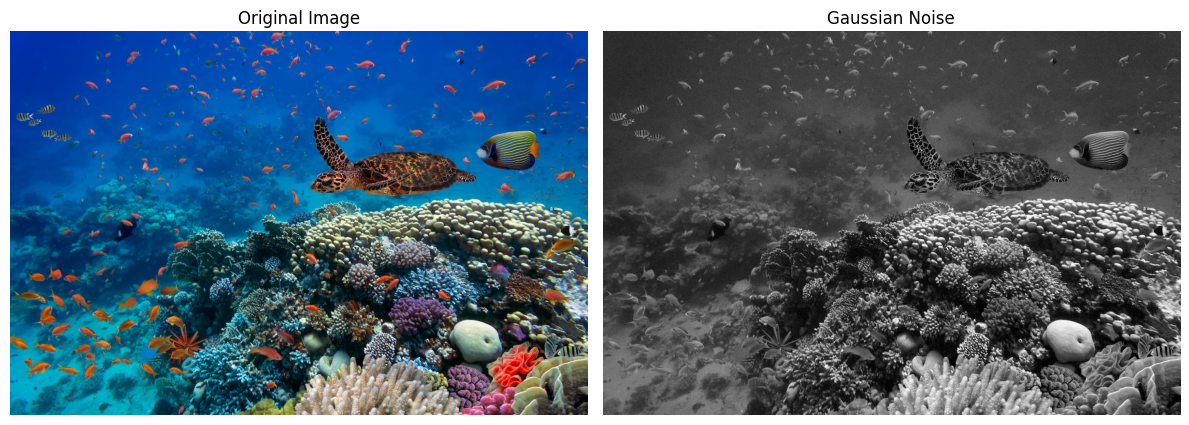

In [20]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

imageCoral = img.imread('Coral.jpg')

if imageCoral.max() > 1.0:
    imageCoral = imageCoral / 255.0
    
# Extract RGB channels
# asked chatgpt how to index into an img array
red = imageCoral[:,:,0]
green = imageCoral[:,:,1]
blue = imageCoral[:,:,2]

gamma = 1.04
r_const = 0.299
g_const = 0.587
b_const = 0.114

grayscaleCoral = np.clip((r_const * red   ** gamma +
                          g_const * green ** gamma +
                          b_const * blue  ** gamma), 0.0, 1.0).astype(np.float32)


def add_gaussian_noise(image, mean=0.0, sigma=0.02):
    gaussianImg = image.copy()

    # Convert image to float to avoid overflow/underflow
    image_float = image.astype(np.float32)
    # Generate Gaussian noise
    noise = np.random.normal(mean, sigma, image.shape)
    # Add noise and clip to valid range [0, 255]
    gaussianImg = np.clip(image_float + noise, 0.0, 1.0).astype(np.float32)

    return gaussianImg


gaussNoiseCoral = add_gaussian_noise(grayscaleCoral)

# 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(imageCoral, cmap='gray', vmin=0.0, vmax=1.0)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Grayscale image
axes[1].imshow(gaussNoiseCoral, cmap='gray', vmin=0.0, vmax=1.0)
axes[1].axis('off')
axes[1].set_title("Gaussian Noise")

plt.tight_layout()
plt.show()

B) Apply the simple Laplacian operator (choose either the 4- or 8-neighbor kernel) to both 
images. Display the resulting edge magnitude maps. Briefly discuss how noise influences 
the Laplacian response.

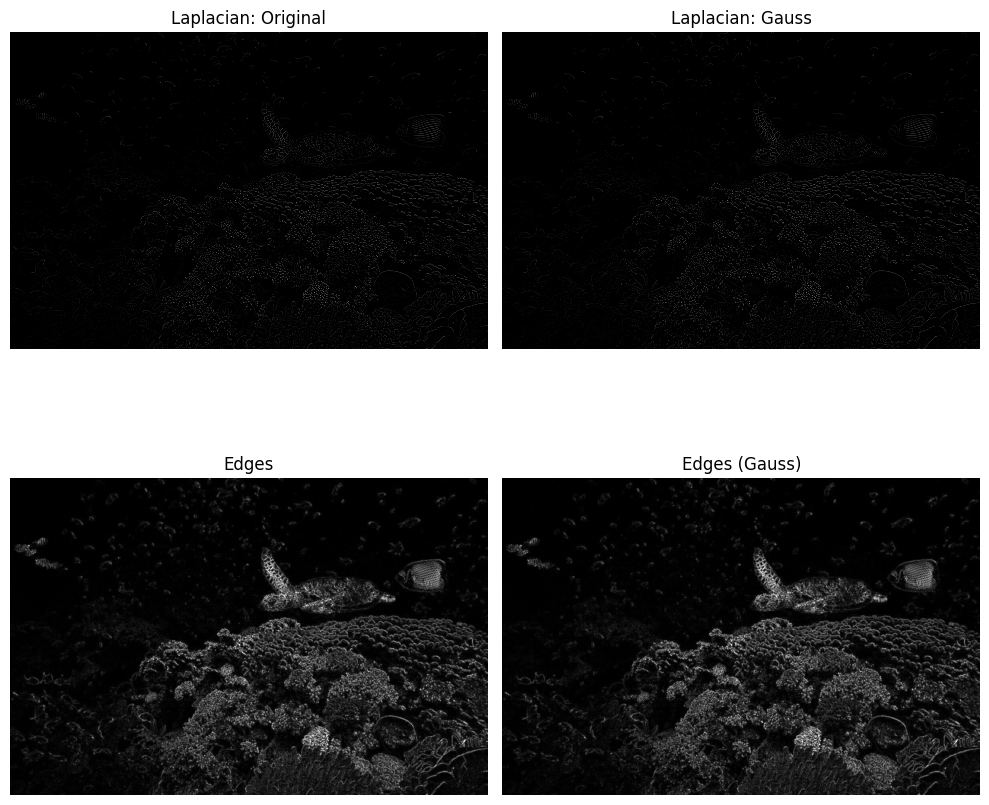

In [40]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    
    imageH, imageW = image.shape
    kernelH, kernelW = kernel.shape
    
    pad_h = kernelH // 2
    pad_w = kernelW // 2
    
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    
    output = np.zeros_like(image)
    
    for i in range(imageH):
        for j in range(imageW):
            neighborhood = padded_image[i:i+kernelH, j:j+kernelW]
            output[i, j] = np.sum(neighborhood * kernel)
            
    return output

def apply_laplacian(image):
    # 4-neighbor Laplacian
    kernel = np.array([
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0]
    ])
    
    laplacian_img = convolve2d(image, kernel)
    
    return laplacian_img

lap_orig = apply_laplacian(grayscaleCoral)
lap_gauss = apply_laplacian(grayscaleCoral)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(lap_orig, cmap='gray', vmin=0.0, vmax=1.0)
axes[0, 0].set_title("Laplacian: Original")
axes[0, 0].axis('off')

axes[0, 1].imshow(lap_gauss, cmap='gray', vmin=0.0, vmax=1.0)
axes[0, 1].set_title("Laplacian: Gauss")
axes[0, 1].axis('off')

axes[1, 0].imshow(np.abs(lap_orig), cmap='gray', vmin=0, vmax=1.0)
axes[1, 0].set_title("Edges")
axes[1, 0].axis('off')

axes[1, 1].imshow(np.abs(lap_gauss), cmap='gray', vmin=0, vmax=1.0)
axes[1, 1].set_title("Edges (Gauss)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

C) Construct and apply the Laplacian of Gaussian (LoG) filter with σ = 1 and σ = 2. Compare 
the results to part (b). Comment on how increasing the Gaussian scale affects edge 
sharpness and noise suppression.

LoG Kernel (σ=1) size: 9x9
LoG Kernel (σ=2) size: 17x17


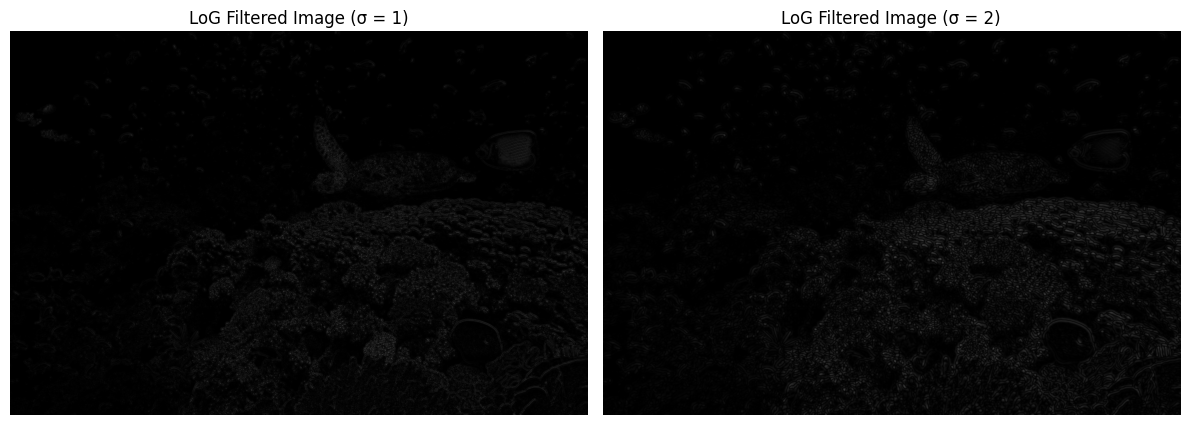

In [59]:
import numpy as np
import scipy.ndimage as ndimage

def log_kernel(sigma, size):

    half = size // 2
    x, y = np.mgrid[-half:half+1, -half:half+1]

    # Calculate the components of the LoG formula
    sigma_sq = sigma**2
    r_sq = x**2 + y**2
    
    # Full LoG equation with lobes
    LoG = (-1 / (np.pi * sigma**4)) * (1 - r_sq / (2 * sigma_sq)) * np.exp(-r_sq / (2 * sigma_sq))
    
    # Normalize the kernel to ensure the sum is approximately zero. 
    # This is critical for 2nd derivative filters.
    LoG = LoG / np.sum(np.abs(LoG)) # Normalize by absolute sum for robustness
    
    return LoG

def LoG_Filter(image, sigma):
    kernelsize = int( 2 * np.ceil(4 * sigma) + 1)
    print(f"LoG Kernel (σ={sigma}) size: {kernelsize}x{kernelsize}")
    return convolve2d(image, log_kernel(sigma, kernelsize))

sigma1 = 1
sigma2 = 2


coralLog1 = LoG_Filter(grayscaleCoral, sigma1)
coralLog2 = LoG_Filter(grayscaleCoral, sigma2)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the absolute value to show edge strength clearly
axes[0].imshow(np.abs(coralLog1), cmap='gray', vmin=0, vmax=1.0)
axes[0].set_title(f"LoG Filtered Image (σ = 1)")
axes[0].axis('off')

axes[1].imshow(np.abs(coralLog2), cmap='gray', vmin=0, vmax=1.0)
axes[1].set_title(f"LoG Filtered Image (σ = 2)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

D) Implement the Difference of Gaussian (DoG) detector using two Gaussian filters with σ₁ = 
1 and σ₂ = 2. Display the DoG edge map and compare it with the LoG output. Mention one 
computational advantage of DoG over LoG 

LoG Kernel (σ=1.5) size: 13x13


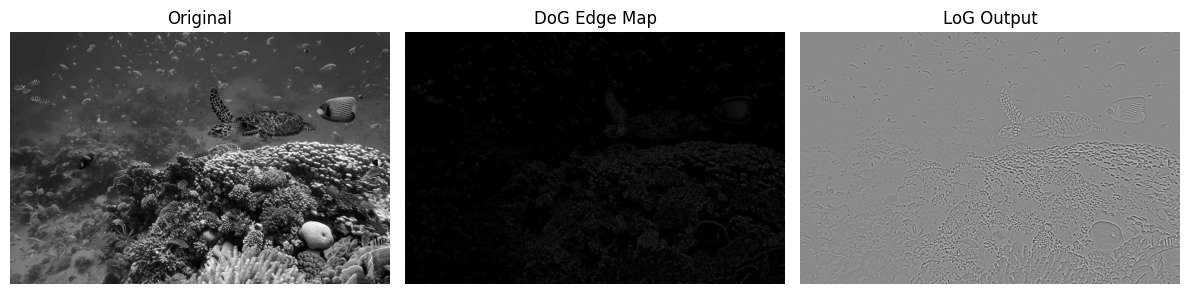

In [64]:
def computeFFT(image):
    return np.fft.fft2(image)

def shiftDFT(dft):
    return np.fft.fftshift(dft)

def invertedShiftDFT(dft):
    return np.fft.ifftshift(dft)

def InverseFFT(dft):
    return np.fft.ifft2(dft)

def FTgaussian(u, v, sigma):
    return (np.exp(-2 * np.pi**2 * sigma**2 * (u**2 + v**2))) 

def DoG_filter(image, sigma1, sigma2):
    H, W = image.shape

    # create a coordinate gride at 0
    u = (np.arange(H) - H // 2) / H
    v = (np.arange(W) - W // 2) / W
    U, V = np.meshgrid(u, v, indexing='ij')

    gassianMask1 = FTgaussian(U, V, sigma1)
    gassianMask2 = FTgaussian(U, V, sigma2)

    DoG = gassianMask1 - gassianMask2
    
    return DoG

grayscaleCoralDFT = computeFFT(grayscaleCoral)
CoralDFTshifted = shiftDFT(grayscaleCoralDFT)

# DoG
DoGmask = DoG_filter(grayscaleCoral, sigma1=1, sigma2=2)
DoG_freq = CoralDFTshifted * DoGmask
DoGEdgeMap = np.abs(InverseFFT(np.fft.ifftshift(DoG_freq)))

# LoG
LoG = LoG_Filter(grayscaleCoral, sigma=1.5)
LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Display the absolute value to show edge strength clearly
axes[0].imshow(np.abs(grayscaleCoral), cmap='gray', vmin=0.0, vmax=1.0)
axes[0].set_title(f"Original")
axes[0].axis('off')

axes[1].imshow(np.abs(DoGEdgeMap), cmap='gray', vmin=0.0, vmax=1.0)
axes[1].set_title(f"DoG Edge Map")
axes[1].axis('off')

axes[2].imshow(np.abs(LoG), cmap='gray', vmin=0.0, vmax=1.0)
axes[2].set_title(f"LoG Output")
axes[2].axis('off')

plt.tight_layout()
plt.show()


E) Apply the Canny edge detector to both the clean and noisy images using appropriate low and high thresholds. Display the resulting edge maps.

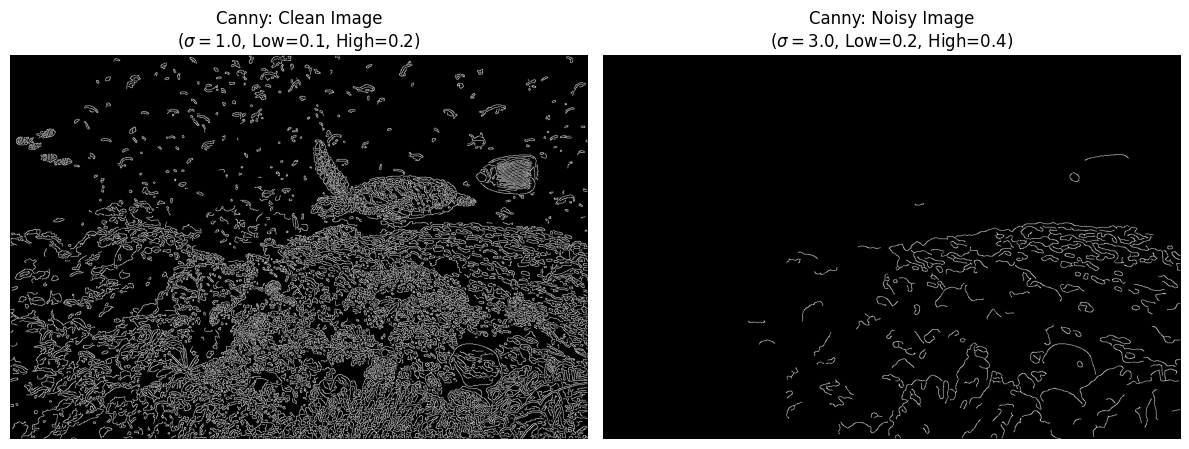

In [76]:
from skimage import feature

# --- 1. Apply Canny to CLEAN Image ---
# Sigma = 1.0 (Standard smoothing)
# Low/High Thresholds = 0.1 / 0.2 (Detects fine details)
canny1 = feature.canny(grayscaleCoral, sigma=1.0, low_threshold=0.1, high_threshold=0.2)


# --- 2. Apply Canny to NOISY Image ---
# Sigma = 3.0 (Heavy smoothing to kill the "static")
# Thresholds = 0.2 / 0.4 (Higher limits to ignore the noise floor)
canny2 = feature.canny(gaussNoiseCoral, sigma=3.0, low_threshold=0.2, high_threshold=0.4)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(canny1, cmap='gray')
axes[0].set_title("Canny: Clean Image\n($\sigma=1.0$, Low=0.1, High=0.2)")
axes[0].axis('off')

axes[1].imshow(canny2, cmap='gray')
axes[1].set_title("Canny: Noisy Image\n($\sigma=3.0$, Low=0.2, High=0.4)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

F) Combine all results (Laplacian, LoG, DoG, Canny) in a single 2×2 figure grid. Briefly, summarize which method provides the most reliable edges under noise and why 
smoothing before differentiation generally improves performance. 

(-0.5, 1199.5, 796.5, -0.5)

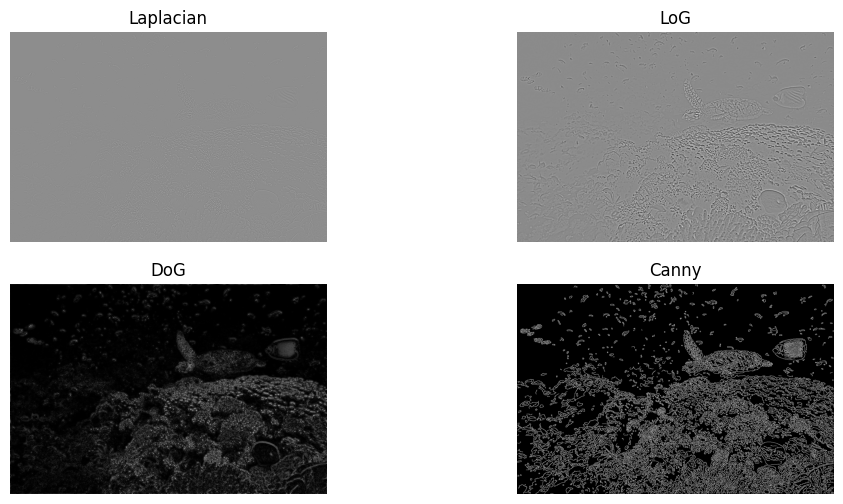

In [78]:

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0,0].imshow(lap_orig, cmap='gray')
axes[0,0].set_title("Laplacian")
axes[0,0].axis('off')

axes[0, 1].imshow(LoG, cmap='gray')
axes[0, 1].set_title("LoG")
axes[0, 1].axis('off')

axes[1, 0].imshow(DoGEdgeMap, cmap='gray')
axes[1, 0].set_title("DoG")
axes[1, 0].axis('off')

axes[1, 1].imshow(canny1, cmap='gray')
axes[1, 1].set_title("Canny")
axes[1, 1].axis('off')


## Case Study: YOLO (You Only Look Once) Algorithm 

The goal of this problem is to study how the YOLO (“You Only Look Once”) detector behaves 
on still images. Use the YOLO model and Python package linked in the Module 8 notes 

A) Run the provided YOLO model on the given image Mountain.png. Display the resulting detections by overlaying the predicted bounding boxes and class labels. List all detected object classes and their confidence scores in a table. 

In [11]:
import torch
import pandas as pd
import matplotlib.pyplot as plt  # <--- This was missing

# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Run Inference
image_path = 'Mountain.png'
results = model(image_path)

# --- 1. Print the Data Table First ---
df = results.pandas().xyxy[0]
table_data = df[['name', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']]

print("\n--- Detected Objects Table ---")
print(f"{'Class Label':<15} | {'Confidence':<10} | {'Bounding Box (x1, y1, x2, y2)'}")
print("-" * 65)

if table_data.empty:
    print("No objects detected.")
else:
    for index, row in table_data.iterrows():
        label = row['name']
        conf = row['confidence']
        bbox = f"[{row['xmin']:.0f}, {row['ymin']:.0f}, {row['xmax']:.0f}, {row['ymax']:.0f}]"
        print(f"{label:<15} | {conf:.4f}     | {bbox}")

annotated_img = results.render()[0] # This is a numpy array of the image

output_file = 'result_detection.png'

# You must DRAW it first before you can SAVE it
plt.figure(figsize=(12, 8))
plt.imshow(annotated_img)
plt.axis('off')
plt.title("YOLOv5 Detections")

# Now save the current figure to the filename
plt.savefig(output_file, bbox_inches='tight') # bbox_inches removes extra whitespace
print(f"\nImage saved to {output_file} (Check your file explorer)")


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=70.0.0', 'urllib3>=2.5.0 ; python_version > "3.8"'] not found, attempting AutoUpdate...


Using cache found in /home/tgreenwood/.cache/torch/hub/ultralytics_yolov5_master


WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "setuptools>=70.0.0" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.
WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "setuptools>=70.0.0" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "gitpython>=3.1.30" "setuptools>=70.0.0" "urllib3>=2.5.0 ; python_version > "3.8"" ' returned non-zero exit status 2.


YOLOv5 🚀 2025-11-27 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/tgreenwood/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



--- Detected Objects Table ---
Class Label     | Confidence | Bounding Box (x1, y1, x2, y2)
-----------------------------------------------------------------
person          | 0.5555     | [804, 656, 933, 730]

Image saved to result_detection.png (Check your file explorer)


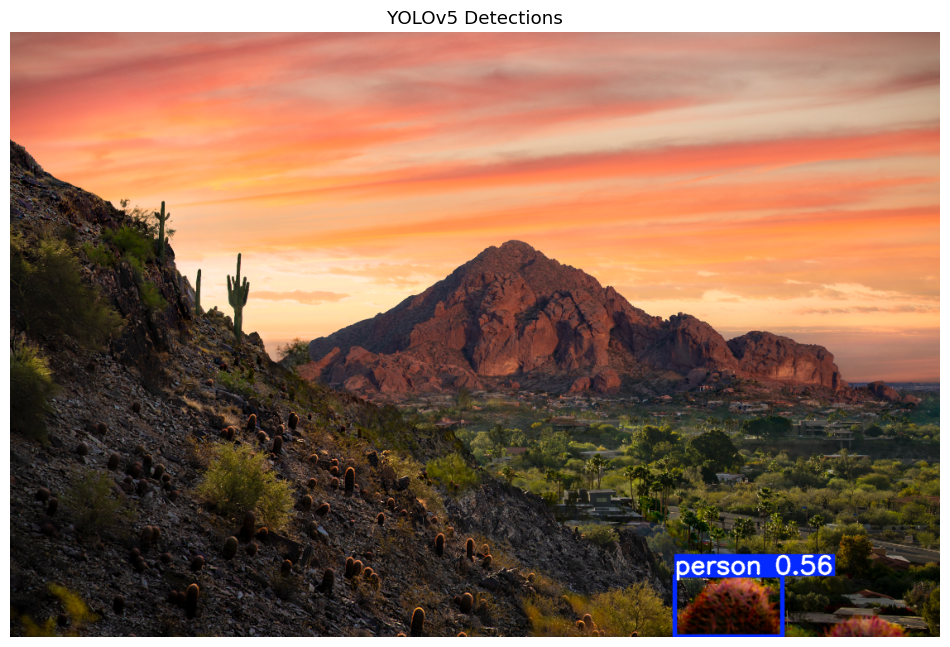

In [9]:
from IPython.display import Image, display

# This bypasses Matplotlib backends and renders the file directly
display(Image(filename='result_detection.png'))

B) Create a blurred version of the reference image using a Gaussian filter with a chosen σ that produces visible edge softening. Run YOLO on this blurred image. Compare the number of detected objects and confidence values with those from part (a). Briefly comment on the effect of blur on YOLO’s detection performance.

In [16]:
def rgb_gaussian_filter(image, window_size, sigma):
    H, W, C = image.shape
    filtered_image = np.zeros_like(image)

    # Loop through Red (0), Green (1), Blue (2)
    for channel in range(C):
        # Extract one channel (H x W)
        single_channel = image[:, :, channel]
        
        filtered_channel = gaussian_filter(single_channel, window_size, sigma)
        
        filtered_image[:, :, channel] = filtered_channel

    return filtered_image


imageMountain = img.imread('Mountain.png')
gaussianMountain = rgb_gaussian_filter(imageMountain, 15, 80)


# 1 row, 2 columns
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#
## Original image
#axes[0].imshow(imageMountain)
#axes[0].axis('off')
#axes[0].set_title("Original Image")
#
## Grayscale image
#axes[1].imshow(gaussianMountain)
#axes[1].axis('off')
#axes[1].set_title("Gauss")

#plt.tight_layout()
#plt.show()

# You must DRAW it first before you can SAVE it
plt.figure(figsize=(12, 8))
plt.imshow(gaussianMountain)
plt.axis('off')

output_file = 'gaussian_mtn.png'

plt.savefig(output_file, bbox_inches='tight') # bbox_inches removes extra whitespace
print(f"\nImage saved to {output_file} (Check your file explorer)")



Image saved to gaussian_mtn.png (Check your file explorer)


C) For a second image, you are provided with YOLO output in a text file (in the data folder, provided with the assignment) containing bounding-box coordinates, class labels, and confidence values. Using a confidence threshold of 0.5, determine which detections would be retained and which would be discarded. Organize the results in table: kept detections and discarded detections.

In [ ]:


# 2. Parse the Data
# We use 'sep='\s+' to handle spaces/tabs between columns
columns = ['Label', 'Confidence', 'x1', 'y1', 'x2', 'y2']
# If loading from a real file, use: df = pd.read_csv('path/to/file.txt', sep='\s+', names=columns, header=None)
df = pd.read_csv(io.StringIO(yolo_output_data), sep=r'\s+', names=columns, header=None)

# 3. Apply Threshold
threshold = 0.5

kept_df = df[df['Confidence'] >= threshold][['Label', 'Confidence', 'x1', 'y1', 'x2', 'y2']]
discarded_df = df[df['Confidence'] < threshold][['Label', 'Confidence', 'x1', 'y1', 'x2', 'y2']]

# 4. Display Results
print(f"Total Detections: {len(df)}")
print(f"Threshold: {threshold}\n")

print("=== KEPT DETECTIONS (Confidence >= 0.5) ===")
print(kept_df.to_string(index=False))

print("\n=== DISCARDED DETECTIONS (Confidence < 0.5) ===")
print(discarded_df.to_string(index=False))

D) Using the same YOLO results for the second image, visually inspect the image and identify at least one false positive and one missed object. Using concepts from image processing (edges, clutter, scale, illumination), give two plausible image-based reasons for each type of error

E) Summarize, the main strengths and limitations of YOLO for multi-object detection on static images. Focus on how blur, contrast, scene complexity, and object size influence YOLO’s outputs, and briefly discuss why a one-pass detection framework is advantageous for image analysis tasks. 